In [4]:
import re
import requests
from bs4 import BeautifulSoup
import datetime
import os
from fpdf import FPDF
import yake
import pytz
import glob
import shutil
import smtplib
from email.message import EmailMessage
import json
import seaborn as sns
import matplotlib.pyplot as plt

def fetch_time():
    current_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
    format_time = current_time.strftime("%Y-%m-%d %H:%M:%S")
    tag_time = str(current_time.day) + str(current_time.month) + str(current_time.year) + str(current_time.hour) + str(current_time.minute) + str(current_time.second)
    
    return format_time, tag_time

def create_pdf(format_time):
    #Convert txt to PDF
    pdf = FPDF()
    # Add a page
    pdf.add_page()

    # set style and size of font
    # that you want in the pdf
    pdf.add_font('DejaVu', '', './fonts/Tinos-Regular.ttf', uni=True)
    pdf.set_font('DejaVu', '', 14)

    #Setting credentials
    pdf.set_text_color(0,0,0)  
    txt_1="FENS Job Market Weekly Feed"
    txt_2="Last updated on: "+str(format_time)+" IST"
    txt_3="github.com/pradhanhitesh"
    pdf.cell(200, 10, txt = txt_1,ln = 1, align = 'C')
    pdf.cell(200, 10, txt = txt_2,ln = 2, align = 'C')
    pdf.cell(200, 10, txt = txt_3,ln = 2, align = 'C')
    pdf.ln(h=6)

    return pdf

def add_element(dict, key, value):
    if key not in dict:
        dict[key] = []
    dict[key].append(value)

def update_data():
    fens_files = glob.glob('./FENS*')
    if len(fens_files) > 0:
        # print("FILES FOUND")
        for i in range(len(fens_files)):
            shutil.move(fens_files[i],'./data/')

    return

def get_metadata(pdf,format_time,tag_time):    
    file_name = "FENS_" + tag_time + ".txt"

    # Gather metadata for job-links
    data_dict = {}
    add_element(data_dict,'Timestamp',format_time)
    
    with open(file_name,'wt') as f :
        urls=["https://www.fens.org/careers/job-market"]
        for url in urls:
            # Send a request to the URL
            response = requests.get(url)
            response.raise_for_status()
            print(f"{format_time} REQUEST SENT!")

            # Parse the content using BeautifulSoup
            soup = BeautifulSoup(response.content, 'html.parser')
            href_tags = soup.find_all(href=True)

            # Fetch job-links
            job_links=[]
            for i in range(len(href_tags)):
                fullstring = str(href_tags[i])
                substring = "https://www.fens.org/careers/job-market/job/"
                try:
                    fullstring.index(substring)
                except ValueError:
                    continue
                else:
                    # print(fullstring)
                    job_links.append(fullstring)

            print(f"{format_time} JOBS FETCHED!")

            for k in range(10):
                if re.sub('<[^<]+?>', '', str(job_links[k])).isdigit():
                    url_job="https://www.fens.org/careers/job-market/job/" + re.sub('<[^<]+?>', '', str(job_links[k])) + "/"
                    print(url_job,file=f)
                    pdf.set_text_color(0,0,255) 
                    pdf.write(4,url_job)
                    pdf.ln(h=5)
                    
                    # Send a request to the URL
                    response = requests.get(url_job)
                    response.raise_for_status()

                    # Parse the content using BeautifulSoup
                    soup = BeautifulSoup(response.content, 'html.parser')

                    # Get title
                    title_tags = soup.find_all('title')
                    title=str(title_tags).split('>')[1].split('<')[0]
                    print("Title: ",title)
                    pdf.set_text_color(0,0,0) 
                    title_text="Title: "+str(title_tags).split('>')[1].split('<')[0]
                    pdf.multi_cell(w=190, h=5, txt=title_text, border=0, align='L', fill=False)

                    # Get other info
                    keywords=['<p>Job ID:','<p><b>Position:','<p><b>Deadline:',
                            '<p><b>Employment Start Date:','<p><b>Country:','<p><b>Institution:','URL:',
                            "<p><b>Department:"]
                    
                    local = []
                    for j in range(len(list(soup.find_all('p')))):
                        for keys in keywords:
                            if str(soup.find_all('p')[j]).find(keys) != -1:
                                print(re.sub('<[^<]+?>', '',str(soup.find_all('p')[j])))
                                local.append(re.sub('<[^<]+?>', '',str(soup.find_all('p')[j])))
                                pdf.write(4,re.sub('<[^<]+?>', '',str(soup.find_all('p')[j])))
                                pdf.ln(h=5)

                    add_element(data_dict,'JobID',list(filter(lambda x: x.startswith('Job ID'), local))[0].split(': ')[1])
                    add_element(data_dict,'Country',list(filter(lambda x: x.startswith('Country'), local))[0].split(': ')[1])

                    # Generate keywords for each job-links from descirption
                    save_des=["<p><b>Description:"]
                    for j in range(len(list(soup.find_all('p')))):
                        for keys in save_des:
                            if str(soup.find_all('p')[j]).find(keys) != -1:
                                text_save = re.sub('<[^<]+?>', '',str(soup.find_all('p')[j]))
                                kw_extractor = yake.KeywordExtractor(top=10, stopwords=None)
                                keywords = kw_extractor.extract_keywords(text_save)
                                text="Keywords: "

                                for kw in range(len(keywords)):
                                    text=text+keywords[kw][0]+"; "
                                    if kw == 9:
                                        print(text)
                                        pdf.multi_cell(w=190, h=5, txt=text, border=0, align='L', fill=False)
                                        pdf.ln(h=5)
    pdf.output("FENS_"+tag_time+".pdf")

    return data_dict

def send_mail(format_time,tag_time):
    msg = EmailMessage()
    msg["From"] = os.environ.get('FROM_ID')
    msg["Subject"] = "FENS Weekly Update" 
    msg["To"] = os.environ.get('TO_ID')
    msg.set_content(f"Dear subscriber, \nPlease find attached the FENS Weekly Update. \nGenerated on {format_time} IST. \n\nRegards,\nHitesh Pradhan")

    with open("FENS_"+ tag_time +".pdf", 'rb') as content_file:
        content = content_file.read()
        msg.add_attachment(content, maintype='application', subtype='pdf', filename="FENS_"+ tag_time +".pdf")

    s = smtplib.SMTP_SSL('smtp.gmail.com')
    s.login(os.environ.get('EMAIL'),os.environ.get('LOGIN_KEY')) #Add your credentials
    s.send_message(msg)

    return

def update_data_json(data_dict):
    with open("data/data.json") as doc:
        docObj = json.load(doc)
        docObj.append(
            data_dict
        )
    with open("data/data.json", 'w') as json_file:
        json.dump(docObj, json_file, 
                  indent=4,  
                  separators=(',',': '))
    return

def count_countries():
    def count_frequency(input_list):
        frequency_dict = {}

        for element in input_list:
            if element in frequency_dict:
                frequency_dict[element] += 1
            else:
                frequency_dict[element] = 1

        return frequency_dict

    with open("data/data.json") as doc:
        docObj = json.load(doc)

    countries = []
    for i in range(len(docObj)):
        countries = countries + docObj[i]['Country']

    store_count = count_frequency(countries)

    return store_count

def generate_plot(count_dict,tag_time):
    plt.figure(figsize=(12,5))
    plt.xticks(range(len(count_dict)), list(count_dict.keys()), rotation=45)

    ax = sns.barplot(list(count_dict.keys()),list(count_dict.values()))
    ax.bar_label(ax.containers[0])

    plt.savefig('CountryCount' + tag_time +'.png',bbox_inches='tight')
    plt.close()

    return

def generate_html_plot(tag_time):
    all_files = os.listdir("./")
    png_files = [file for file in all_files if file.endswith('.png')]

    template_vars = {
        'plot' : f'<img src="{png_files[0]}" width="650" height="400">',
        'timestamp' : tag_time
        }
    
    return template_vars

In [117]:
format_time, tag_time = fetch_time()
pdf = create_pdf(format_time)

update_data()         
data_dict = get_metadata(pdf,format_time,tag_time)

2024-01-22 17:52:21 REQUEST SENT!
2024-01-22 17:52:21 JOBS FETCHED!
Title:  PhD Position in electrophysiology of tick neurons - Federation of European Neuroscience Societies
Job ID: 117507
Position: Ph.D. Student
Deadline: 15 March 2024
Employment Start Date: 1 October 2024
Country: France
Institution: University of Orleans (France)/P2E laboratory/ Team : Neurobiology and Neuropharmacology of Ion Channels (NNIC)
Department: Biology and Biochemistry
URL: https://www.univ-orleans.fr/fr/p2e/equipes/neurobiologie-et-neuropharmacologie-des-canaux-ioniques
Keywords: tick Ixodes ricinus; nicotinic acetylcholine receptors; Project title; Pharmacology and intracellular; tick Ixodes; Ixodes ricinus; neuronal nicotinic acetylcholine; Ixodes ricinus neuronal; acetylcholine receptors; nicotinic acetylcholine; 
Title:  Application Specialist - Federation of European Neuroscience Societies
Job ID: 117502
Position: Commercial Position
Deadline: 16 February 2024
Employment Start Date: 4 March 2024
Coun

In [113]:
update_data_json(data_dict)

In [49]:
def count_countries():
    def count_frequency(input_list):
        frequency_dict = {}

        for element in input_list:
            if element in frequency_dict:
                frequency_dict[element] += 1
            else:
                frequency_dict[element] = 1

        return frequency_dict

    with open("data/data.json") as doc:
        docObj = json.load(doc)

    countries = []
    for i in range(len(docObj)):
        countries = countries + docObj[i]['Country']

    store_count = count_frequency(countries)

    return store_count

def generate_plot(count_dict,,tag_time):
    plt.figure(figsize=(12,5))
    plt.xticks(range(len(count_dict)), list(count_dict.keys()), rotation=45)

    ax = sns.barplot(list(count_dict.keys()),list(count_dict.values()))
    ax.bar_label(ax.containers[0])

    plt.savefig('CountryCount' + tag_time +'.png',bbox_inches='tight')
    plt.close()

    return

In [51]:
store_count = count_countries()
generate_plot(count_dict=store_count)

c:\Users\htshp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


In [24]:
def count_frequency(input_list):
    frequency_dict = {}

    for element in input_list:
        if element in frequency_dict:
            frequency_dict[element] += 1
        else:
            frequency_dict[element] = 1

    return frequency_dict

In [30]:
count_frequency(docObj[1]['Country'])

{'Belgium': 1,
 'Germany': 2,
 'Canada': 2,
 'Czech Republic': 1,
 'France': 8,
 'Finland': 1,
 'United States': 1,
 'Sweden': 2,
 'Austria': 1,
 'Poland': 1}

In [35]:
countries = []
for i in range(len(docObj)):
    countries = countries + docObj[i]['Country']

In [42]:
my_dict = count_frequency(countries)

c:\Users\htshp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '1'),
 Text(0, 0, '8'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '1'),
 Text(0, 0, '1')]

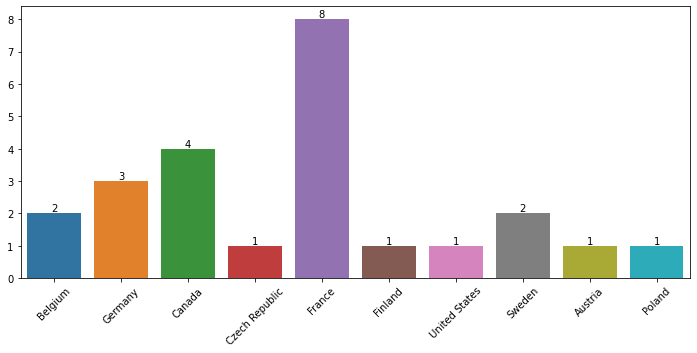

In [48]:

plt.figure(figsize=(12,5))
plt.xticks(range(len(my_dict)), list(my_dict.keys()), rotation=45)

ax = sns.barplot(list(my_dict.keys()),list(my_dict.values()))
ax.bar_label(ax.containers[0])